In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pprint
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import xgboost as xgb

In [3]:
def load_data():
    orig_data = pd.read_excel("OppScrData.xlsx")
    for col in orig_data.columns:
      new_col = '_'.join(col.split())

      if new_col.startswith('Unnamed'):
        orig_data.drop(col, axis = 1, inplace=True)
      else:
        orig_data.rename(columns={col:new_col}, inplace=True)
    
    return orig_data

In [4]:
orig_data = load_data()
print(orig_data.columns)

Index(['Record_ID', 'Visit_ID', 'PT_ID', 'Clinical_F/U_interval_[d_from_CT]',
       'BMI', 'BMI_>30', 'Sex', 'Age_at_CT', 'Tobacco', 'Alcohol_abuse',
       'FRS_10-year_risk_(%)', 'FRAX_10y_Fx_Prob_(Orange-w/_DXA)',
       'FRAX_10y_Hip_Fx_Prob_(Orange-w/_DXA)', 'Met_Sx', 'CLINICAL_OUTCOMES',
       'DEATH_[d_from_CT]', 'CVD_DX', 'CVD_DX_Date_[d_from_CT]',
       'Heart_failure_DX', 'Heart_failure_DX_Date_[d_from_CT]', 'MI_DX',
       'MI_DX_Date_[d_from_CT]', 'Type_2_Diabetes_DX',
       'Type_2_Diabetes_DX_Date_[d_from_CT]', 'Femoral_neck_fracture_DX',
       'Femoral_neck_fracture_DX_Date_[d_from_CT]',
       'Unspec_femoral_fracture_DX',
       'Unspec_femoral_fracture_DX_Date_[d_from_CT]', 'Forearm_fracture_DX',
       'Forearm_fracture_DX_Date_[d_from_CT]', 'Humerus_fracture_DX',
       'Humerus_fracture_DX_Date_[d_from_CT]', 'Pathologic_fracture_DX',
       'Pathologic_fracture_DX_Date_[d_from_CT]', 'Alzheimers_DX',
       'Alzheimers_DX_Date_[d_from_CT]', 'Primary_Cancer_Site

In [5]:
CT_cols = orig_data.columns[-11:]
print(CT_cols)

Index(['L1_HU_BMD', 'TAT_Area_(cm2)', 'Total_Body_Area_EA_(cm2)',
       'VAT_Area_(cm2)', 'SAT_Area_(cm2)', 'VAT/SAT_Ratio', 'Muscle_HU',
       'Muscle_Area_(cm2)', 'L3_SMI_(cm2/m2)', 'AoCa_Agatston',
       'Liver_HU_(Median)'],
      dtype='object')


In [6]:
death_col_name = 'DEATH_[d_from_CT]'

# Data Analysis

In [7]:
# filter data into train and test
mask = np.isnan(orig_data[death_col_name]) == False

train_df = orig_data[mask]
test_df = orig_data[~mask]

print(orig_data.shape, train_df.shape, test_df.shape)


(9223, 52) (549, 52) (8674, 52)


In [26]:
train_df['Liver_HU_(Median)'] = pd.to_numeric(train_df['Liver_HU_(Median)'], errors='coerce')
train_df['Liver_HU_(Median)'] = train_df['Liver_HU_(Median)'].astype(float)

test_df['Liver_HU_(Median)'] = pd.to_numeric(test_df['Liver_HU_(Median)'], errors='coerce')
test_df['Liver_HU_(Median)'] = test_df['Liver_HU_(Median)'].astype(float)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [10]:
train_df[CT_cols].describe()

,L1_HU_BMD,TAT_Area_(cm2),Total_Body_Area_EA_(cm2),VAT_Area_(cm2),SAT_Area_(cm2),VAT/SAT_Ratio,Muscle_HU,Muscle_Area_(cm2),L3_SMI_(cm2/m2),AoCa_Agatston,Liver_HU_(Median)
count,545.000000,533.000000,533.000000,533.000000,533.000000,533.000000,546.000000,546.000000,518.000000,549.000000,536.000000
mean,150.933945,407.463576,721.280648,212.317173,199.006059,1.220341,20.823904,150.865364,52.222525,2470.798517,53.554104
std,47.519919,202.357058,244.081176,134.887377,105.992783,0.927551,15.294655,46.480067,14.552679,3572.541978,10.775225
min,55.000000,20.072442,321.824242,9.363115,9.453488,0.189480,-118.307532,27.922454,10.904482,0.000000,-21.000000
25%,113.000000,257.278049,543.067568,115.954610,119.235135,0.663636,11.864264,117.704180,42.560308,131.342000,49.750000
50%,146.000000,391.636585,682.394595,188.723404,184.651515,0.980474,22.137761,149.117110,51.578709,872.589000,56.000000
75%,180.000000,526.537838,854.573171,278.625714,260.224242,1.477486,30.875938,185.828842,61.716566,3541.443000,60.000000
max,359.000000,1046.928378,1641.385621,837.921569,603.846911,10.827769,73.980641,280.415981,117.735193,31723.945000,105.000000


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


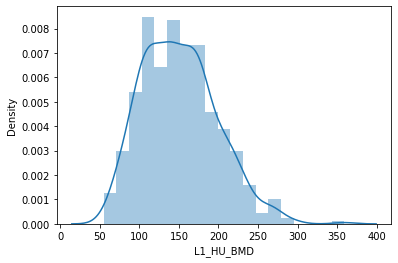

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


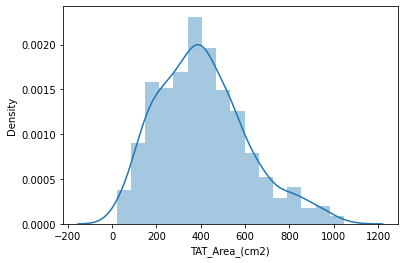

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


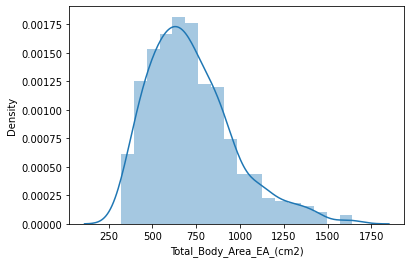

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


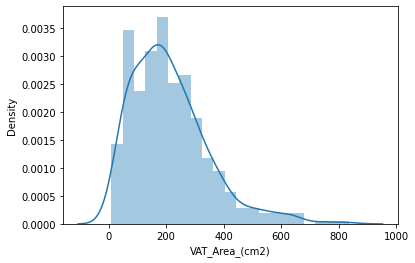

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


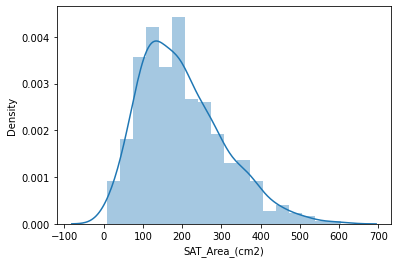

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


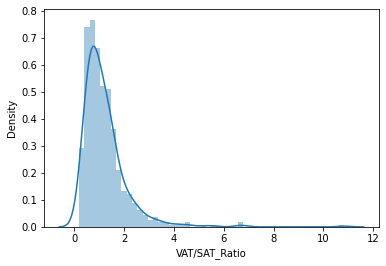

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


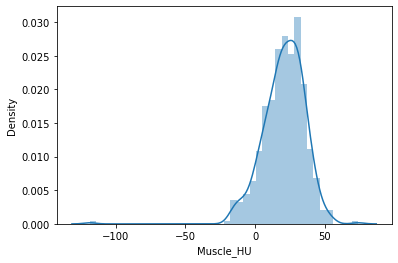

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


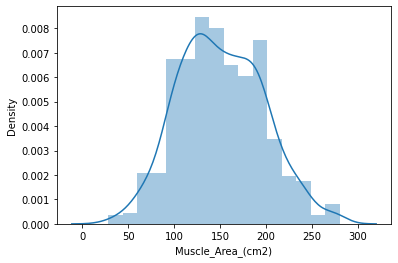

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


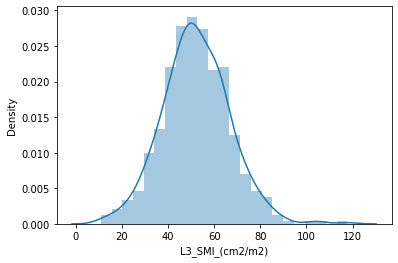

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


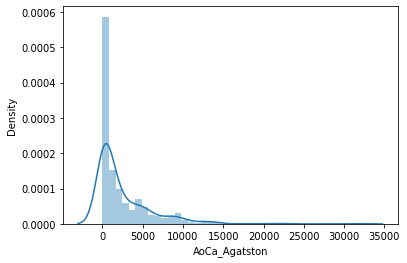

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


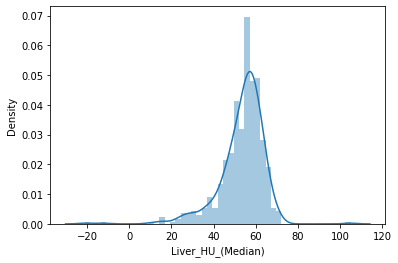

In [11]:
# visualize each feature to check data skewness
for col in CT_cols:
  sns.distplot(train_df[col], label=col)
  plt.show()

In [12]:
# cut AoCa_Agatston at 15000

col_AoCa_Agatston = 'AoCa_Agatston'
col_Liver_HU_Median = 'Liver_HU_(Median)'

train_df[col_AoCa_Agatston].clip(upper=15000, inplace=True)
train_df[col_Liver_HU_Median].clip(lower=0, upper=80, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:7249: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [13]:
# calculate median values for all CT cols

fixed_train_df = train_df.copy()
for col in CT_cols:
  fixed_train_df.fillna(train_df[col].mean(), inplace=True)

mean_map = dict()
copy_mean_map = dict()

for col in CT_cols:
  mean_map[col] = train_df[col].mean()
  copy_mean_map[col] = fixed_train_df[col].mean()

pprint.pprint(mean_map)
pprint.pprint(copy_mean_map)

print('Not much change if we replace with mean')

{'AoCa_Agatston': 2411.062976320579,
 'L1_HU_BMD': 150.93394495412844,
 'L3_SMI_(cm2/m2)': 52.22252509011307,
 'Liver_HU_(Median)': 53.57089552238806,
 'Muscle_Area_(cm2)': 150.86536367976097,
 'Muscle_HU': 20.82390429670328,
 'SAT_Area_(cm2)': 199.00605851433696,
 'TAT_Area_(cm2)': 407.463576247073,
 'Total_Body_Area_EA_(cm2)': 721.2806478610561,
 'VAT/SAT_Ratio': 1.2203408526373185,
 'VAT_Area_(cm2)': 212.31717303825647}
{'AoCa_Agatston': 2411.062976320579,
 'L1_HU_BMD': 150.93394495412844,
 'L3_SMI_(cm2/m2)': 57.79639397132344,
 'Liver_HU_(Median)': 55.87639578215606,
 'Muscle_Area_(cm2)': 150.8657384408231,
 'Muscle_HU': 21.53488812543238,
 'SAT_Area_(cm2)': 197.60504974026895,
 'TAT_Area_(cm2)': 399.9873028396284,
 'Total_Body_Area_EA_(cm2)': 704.658521728978,
 'VAT/SAT_Ratio': 5.583578859238155,
 'VAT_Area_(cm2)': 210.52822650028563}
Not much change if we replace with mean


# Model - Linear Regression and XGBoost

In [18]:
def plot_chrono_bio(chrono_age, bio_age):
  plt.plot(chrono_age, bio_age, 'o')
  plt.title('Chrono vs Bio Age')
  plt.xlabel('Chrono Age')
  plt.ylabel('Bio Age')
  plt.show()

def with_days(train_data, test_data, include_bias=True, max_bio_age=100, max_bio_subtract = 2000, decay_rate = 0.002):
  df_train = train_data.copy()
  df_test = test_data.copy()
  # fill test_df with median values, the same values that were used to fill train_data
  for col in CT_cols:
    df_test.fillna(mean_map[col], inplace=True)
  
  C = max_bio_subtract
  K = decay_rate

  df_train['Decay_Days'] = df_train.apply(lambda row: 18 + C*(1 - np.exp(-K*row['DEATH_[d_from_CT]'])), axis=1)
  df_train['Bio_Age_AT_CT[DAYS]'] = df_train.apply(lambda row: max_bio_age*365 - row['Decay_Days'], axis=1)

  X = df_train[CT_cols]
  Y = df_train['Bio_Age_AT_CT[DAYS]']
  chrono_age = np.array(df_test['Age_at_CT'])

  # Linear Regression
  reg = LinearRegression(fit_intercept=include_bias).fit(X, Y)
  bio_age = reg.predict(df_test[CT_cols]).reshape(chrono_age.shape)/365
  plot_chrono_bio(chrono_age, bio_age)

  # XGBoost
  model = xgb.XGBRegressor(n_estimators=500, max_depth=7, eta=0.01, subsample=1, colsample_bytree=1)
  model.fit(X, Y)
  bio_age = model.predict(df_test[CT_cols]).reshape(chrono_age.shape)/365
  plot_chrono_bio(chrono_age, bio_age)

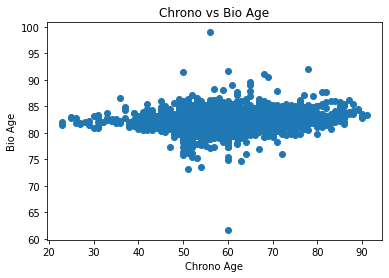

[23:35:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


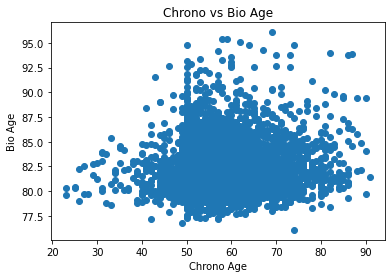

In [25]:
with_days(fixed_train_df, test_df, include_bias=True, max_bio_age=100, max_bio_subtract=8000, decay_rate = 0.001)
# with_days(fixed_train_df, test_df, include_bias=False)